In [2]:
#!/bin/python
## singularity shell --nv ../images/scvi.sif
## or use the conda env for easier running of notebooks
import scanpy as sc
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import captum.attr

device = "cuda" if torch.cuda.is_available() else "cpu"
if device != "cuda":
    raise ValueError("GPU could not be found")

## Prepare data for analysis

In [3]:
###
# Setup data
###

ad = sc.read_h5ad("e75.h5ad")
#keep only hvgs for easier modelling
# need to copy it for the next overwriting step to work properly
ad = ad[:, ad.var.is_hvg].copy()
#make it dense as we already filtered for HVGs
ad.X = ad.X.todense()
ad.X = ad.X.astype("float32")
#make labels numeric
celltypes, ind = np.unique(ad.obs.celltype, return_inverse=True)
ad.obs["celltype_int"] = ind

print(pd.crosstab(ad.obs.pool, ad.obs["sample"]))
# Take sample 6 as test
test_ad = ad[ad.obs["sample"]==6]
train_ad = ad[ad.obs["sample"]!=6]

sample   2    3    4     6     19    20
pool                                   
2       321    0    0     0     0     0
3         0  400    0     0     0     0
4         0    0  255     0     0     0
6         0    0    0  2547     0     0
16        0    0    0     0  5920  1551


## Create pytorch infrastructure for our data and model

In [4]:
#Dataset structures and instantiation
class scrnaDataset(Dataset):
    def __init__(self, ad_obj, device="cuda"):
        self.labels = torch.from_numpy(ad_obj.obs["celltype_int"].to_numpy()).to(device)
        self.expr = torch.tensor(ad_obj.X).to(device)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        slice = self.expr[idx,:]
        label = self.labels[idx]
        return slice, label


train_data = scrnaDataset(ad_obj=train_ad)
train_loader = DataLoader(train_data, batch_size = 60, shuffle=True)

test_data = scrnaDataset(ad_obj=test_ad)
test_loader = DataLoader(test_data, batch_size = 60, shuffle=True)

class MyFirstMLP(nn.Module):
    def __init__(self, dim_in, dim_out=30):
        super(MyFirstMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim_in, 64),
            nn.ReLU(),
            nn.Linear(64, dim_out)
        )

    def forward(self, x):
        logits = self.mlp(x)
        return logits

model = MyFirstMLP(dim_in = train_ad.shape[1], dim_out = len(train_ad.obs.celltype.unique())).to(device)
print(model)

MyFirstMLP(
  (mlp): Sequential(
    (0): Linear(in_features=1497, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=30, bias=True)
  )
)


## Run an example cell (random, except high Ttr) through model

In [5]:

ex = torch.rand(1, train_ad.shape[1], device=device)
ttr_index = np.where(train_ad.var.SYMBOL == "Ttr")
ex[0, ttr_index] = 10

logits = model(ex)
pred_probab = nn.Softmax(dim=1)(logits)
print("Celltype:", celltypes[np.argmax(pred_probab.cpu().detach().numpy())], "\np=",np.max(pred_probab.cpu().detach().numpy()))


Celltype: Caudal epiblast 
p= 0.04195483


/tmp/ipykernel_192113/4099750633.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  ex[0, ttr_index] = 10


## Train the model

In [7]:
learning_rate = 1e-3
batch_size = 60
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 200
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
# print("Done!")



## Investigate the robustness of the model

Celltype: Visceral endoderm 
p= 0.32878786


<AxesSubplot:>

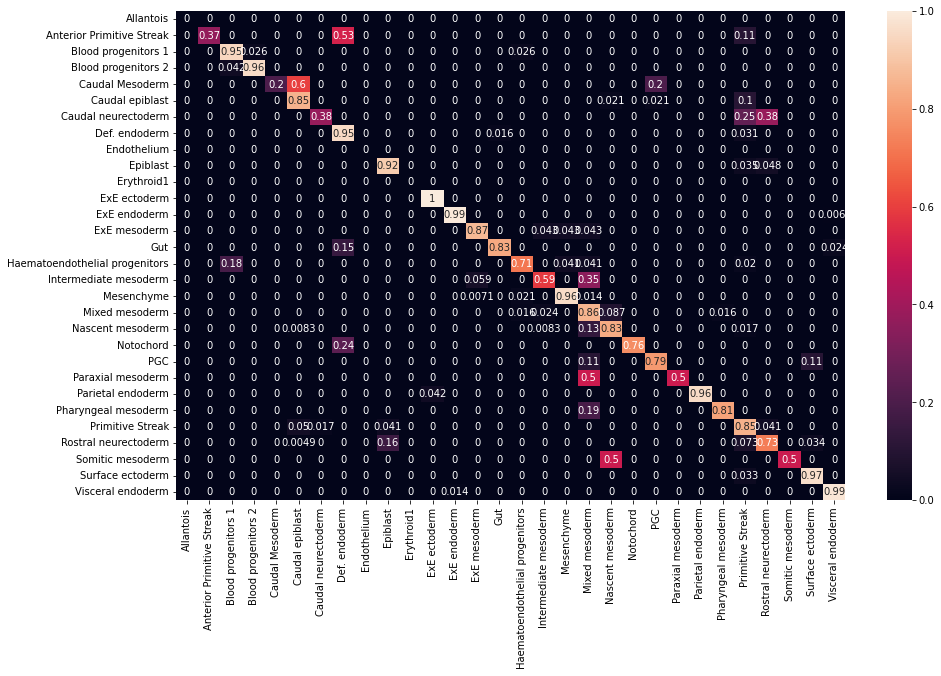

In [8]:

#Return to our dummy ExE endoderm cell
logits = model(ex)
pred_probab = nn.Softmax(dim=1)(logits)

print("Celltype:", celltypes[np.argmax(pred_probab.cpu().detach().numpy())], "\np=",np.max(pred_probab.cpu().detach().numpy()))

def make_confusion(loader, model, names=celltypes):
    all_pred=[]
    all_truth=[]
    for data, labels in loader:
        pred = model(data)
        choices = np.apply_along_axis(np.argmax, 1, pred.cpu().detach().numpy())
        all_pred.extend(choices)
        truth = labels.cpu().detach().numpy()
        all_truth.extend(truth)
    cf_matrix = confusion_matrix(names[all_truth], names[all_pred], labels=names, normalize="true")
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in names],
                        columns = [i for i in names])
    return df_cm

cn = make_confusion(test_loader, model)    
plt.figure(figsize = (15,9))
sn.heatmap(cn, annot=True)

## Examining feature importance

In [9]:
lift = captum.attr.DeepLift(model)

attr_vals = []
attr_labs = []
for dat, lab in test_loader:
    attr_test, delta = lift.attribute(dat, return_convergence_delta=True, target = lab)
    attr_vals.append(attr_test.detach().cpu())
    attr_labs.append(lab.detach().cpu())
attr_vals = torch.cat(attr_vals).detach().cpu().numpy()
attr_labs = torch.cat(attr_labs).detach().cpu().numpy()


/data/jgriffiths/anaconda3/envs/scvi/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/data/jgriffiths/anaconda3/envs/scvi/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [10]:
arr=np.zeros(shape=(attr_vals.shape[1],len(celltypes)))
for i in range(len(celltypes)):
    arr[:,i] = np.mean(attr_vals[attr_labs==i,:], axis=0)


/data/jgriffiths/anaconda3/envs/scvi/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/jgriffiths/anaconda3/envs/scvi/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [11]:
tops = pd.DataFrame()
for i in range(len(celltypes)):
    index = np.argpartition(arr[:,i], -5)[-5:]
    index = index[np.argsort(arr[index,i])]
    tops.loc[:,i] = test_ad.var.SYMBOL.iloc[index].values

tops.columns = celltypes

In [12]:
# print(tops)
print(tops["ExE endoderm"])

0     Fth1
1     Apom
2    Apoa1
3      Ttr
4     Apoe
Name: ExE endoderm, dtype: category
Categories (1497, object): ['0610005C13Rik', '0610040J01Rik', '1110017D15Rik', '1500009L16Rik', ..., 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4']


['Fth1', 'Apom', 'Apoa1', 'Ttr', 'Apoe']
['ENSMUSG00000002985' 'ENSMUSG00000032083' 'ENSMUSG00000024391'
 'ENSMUSG00000061808' 'ENSMUSG00000024661']


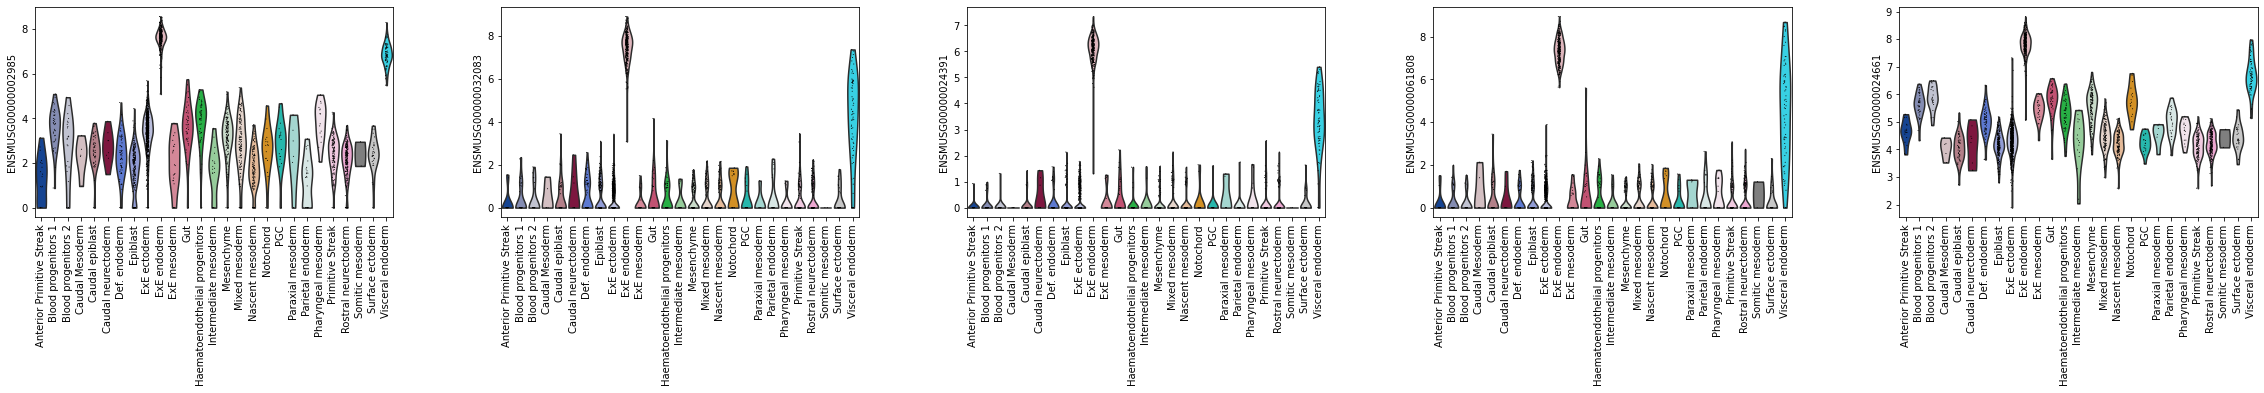

In [60]:
def to_ensembl(symbols, ad = test_ad):
    return ad.var.ENSEMBL[ad.var.SYMBOL.isin(symbols)].values

mgi=tops["ExE endoderm"].values.tolist()
ens=to_ensembl(mgi)

sc.pl.violin(test_ad, ens, groupby='celltype', rotation = 90)